In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [204]:
import numpy as np
import pandas as pd
from scipy import stats

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [29]:
# what columns exist on each table?
inspector = inspect(engine)

meas_columns = inspector.get_columns('measurement')
print("Measurement")
for c in meas_columns:
    print(c['name'], c["type"])
    
station_columns = inspector.get_columns('station')
print("\nStations")
for c in station_columns:
    print(c['name'], c["type"])

Measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Stations
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


## Design a query to retrieve the last 12 months of precipitation data and plot the results:

In [11]:
## Calculate the date 1 year ago from the last data point in the database:

# get last date contained in the dataset for reference
last_date = session.query(Measurement.date).\
            order_by(Measurement.date.desc()).first()
print(f"Last date is: {last_date[0]}")

# 2017 not a leap year so can simply subtract 365 days
last_year_date = (dt.datetime.strptime(last_date[0],'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
print(f"Date from one year ago is: {last_year_date}")

Last date is: 2017-08-23
Date from one year ago is: 2016-08-23


In [15]:
# Perform a query to retrieve the data and precipitation scores
measurement_cols = (Measurement.date, Measurement.prcp)

prcp_data = session.query(*measurement_cols).\
            filter(Measurement.date >= last_year_date).all()
prcp_data[:5]

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0)]

In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data,columns=['date','precipitation'])
prcp_df.head()

,date,precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [17]:
# Sort the dataframe by date
prcp_df.set_index(prcp_df['date'],inplace=True)
prcp_df = prcp_df.sort_index()

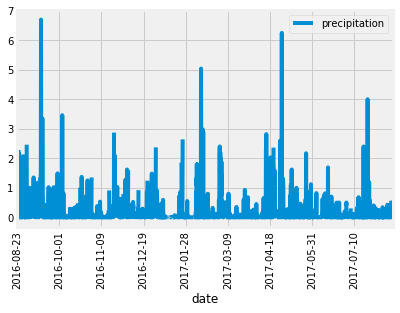

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_df.plot(rot=90);

In [19]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Design a query to temperature observation data (tobs) from active stations and plot the results:

In [20]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(Station.id)).all()
station_count

[(9)]

In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
count_by_station =  session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
count_by_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
USC00519281_data =  session.query(Measurement.date,Measurement.tobs).\
                    filter(Measurement.station == 'USC00519281').\
                    filter(Measurement.date > last_year_date).all()
USC00519281_data[:5]

[('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0)]

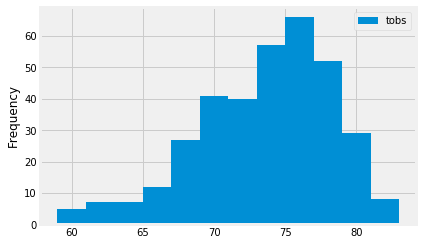

In [24]:
USC00519281_df= pd.DataFrame(USC00519281_data)
USC00519281_df.plot(kind="hist",bins=12);

## Optional Challenge Assignment

### Temperature Analysis I

Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?

You may either use SQLAlchemy or pandas's read_csv() to perform this portion.

Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.

Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

In [243]:
# return the raw data from each month
june_data = session.query(Measurement.date, Measurement.tobs).filter(func.strftime("%m",Measurement.date) == '06').all()
december_data = session.query(Measurement.date, Measurement.tobs).filter(func.strftime("%m",Measurement.date) == '12').all()

# convert raw data to DataFrames to label and then concatenate into one DataFrame
june_df = pd.DataFrame(june_data,columns=["Date","Temperature"])
december_df = pd.DataFrame(december_data,columns=["Date","Temperature"])
june_df["Month"] = "June"
december_df["Month"] = "December"
temp_df = pd.concat([june_df,december_df], ignore_index=True)

# calculate the average for both June and December
avg_temp_month = temp_df.groupby("Month").mean()
avg_temp_month

,Temperature
Month,
December,71.041529
June,74.944118


Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

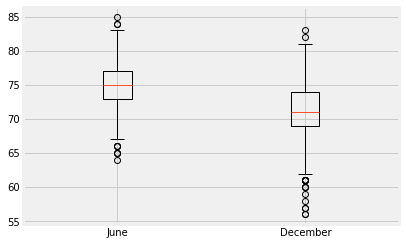

In [262]:
# We will use the t-test to determine if the average temperatures between June and December
# are statistically significantly different. We will use unpaired t-test because we are comparing
# means from separate groups by month that are not dependent on each other

box_data = [june_df["Temperature"],december_df["Temperature"]]
plt.boxplot(box_data,labels=['June', 'December']);
stats.ttest_ind(june_df["Temperature"], december_df["Temperature"])

The boxplot looks like there is overlap but since the p-value is less than 0.05, we can conclude that the difference in means is statistically significant and that there is a meaningful difference in temperature between June and December.

### Temperature Analysis II

In [264]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [276]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# Let's choose the date range 4/10/2014-4/22/2014. That seems like a good amount of time for a trip to Hawaii!
trip_start_date = '2014-04-10'
trip_end_date = '2014-04-22'

last_year_date = (dt.datetime.strptime(last_date[0],'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')

def get_last_year_dates(start_date, end_date):
    last_year_start_date = (dt.datetime.strptime(trip_start_date,'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
    last_year_end_date = (dt.datetime.strptime(trip_end_date,'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
    return last_year_start_date, last_year_end_date

last_start_date, last_end_date = get_last_year_dates(trip_start_date, trip_end_date)

tmin, tavg, tmax = calc_temps(last_start_date,last_end_date)[0]
print(tmin, tavg, tmax)

63.0 72.47524752475248 81.0


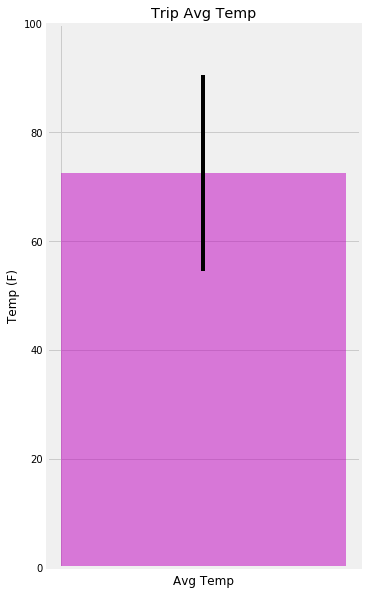

In [266]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize=(5,10));
plt.bar(x="",height=tavg,yerr=tmax-tmin,color='m',alpha=.5,align='edge');
plt.ylim(0,100);
plt.xlabel("Avg Temp")
plt.ylabel("Temp (F)");
plt.title("Trip Avg Temp");

In [267]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# (Need to include columns from both tables in the join for SQLAlchemy before running or else get an error)
query_columns = [Station.station, Station.name, func.sum(Measurement.tobs), Station.latitude, Station.longitude, Station.elevation]

last_year_data =    session.query(*query_columns).\
                    group_by(Measurement.station).\
                    outerjoin(Station, Measurement.station==Station.station).\
                    filter(Measurement.date >= last_start_date).filter(Measurement.date <= last_end_date).\
                    order_by(func.sum(Measurement.tobs).desc()).all()
last_year_data

[('USC00519397', 'WAIKIKI 717.2, HI US', 966.0, 21.2716, -157.8168, 3.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  948.0,
  21.33556,
  -157.71139,
  19.5),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  926.0,
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00513117', 'KANEOHE 838.1, HI US', 924.0, 21.4234, -157.8015, 14.6),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  922.0,
  21.3152,
  -157.9992,
  0.9),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  920.0,
  21.3331,
  -157.8025,
  152.4),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  905.0,
  21.5213,
  -157.8374,
  7.0),
 ('USC00517948', 'PEARL CITY, HI US', 669.0, 21.3934, -157.9751, 11.9),
 ('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  140.0,
  21.4992,
  -158.0111,
  306.6)]

That is really hard to read so let's convert this to a pandas DataFrame for better readability.

In [268]:
pd.DataFrame(last_year_data,
             columns=["Station","Station_Name", "Total_Rainfall", "Latitude", "Longitude", "Elevation"]
            ).sort_values("Total_Rainfall",ascending=False)

,Station,Station_Name,Total_Rainfall,Latitude,Longitude,Elevation
0,USC00519397,"WAIKIKI 717.2, HI US",966.0,21.27160,-157.81680,3.0
1,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",948.0,21.33556,-157.71139,19.5
2,USC00519281,"WAIHEE 837.5, HI US",926.0,21.45167,-157.84889,32.9
3,USC00513117,"KANEOHE 838.1, HI US",924.0,21.42340,-157.80150,14.6
4,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",922.0,21.31520,-157.99920,0.9
5,USC00516128,"MANOA LYON ARBO 785.2, HI US",920.0,21.33310,-157.80250,152.4
6,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",905.0,21.52130,-157.83740,7.0
7,USC00517948,"PEARL CITY, HI US",669.0,21.39340,-157.97510,11.9
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",140.0,21.49920,-158.01110,306.6


### Daily Rainfall Average

In [270]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [275]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
print(f"The trip dates are {trip_start_date} to {trip_end_date}")

The trip dates are 2014-04-10 to 2014-04-22


In [294]:
# Use the start and end date to create a range of dates
s_date = dt.datetime.strptime(trip_start_date,'%Y-%m-%d')
e_date = dt.datetime.strptime(trip_end_date,'%Y-%m-%d') 
delta = e_date - s_date
normals = []

for i in range(delta.days + 1):
    day = s_date + dt.timedelta(days=i)
    # Strip off the year and save a list of %m-%d strings
    month_day = dt.datetime.strftime(day,'%m-%d')
    normals.append(month_day)
    
normals

['04-10',
 '04-11',
 '04-12',
 '04-13',
 '04-14',
 '04-15',
 '04-16',
 '04-17',
 '04-18',
 '04-19',
 '04-20',
 '04-21',
 '04-22']

In [296]:
# Loop through the list of %m-%d strings and calculate the normals for each date
normal_list = []
for day in normals:
    normal_list.append(daily_normals(day)[0])
    
normal_list

[(64.0, 71.40350877192982, 79.0),
 (65.0, 72.49180327868852, 82.0),
 (65.0, 72.22413793103448, 80.0),
 (64.0, 71.52542372881356, 79.0),
 (65.0, 72.75, 81.0),
 (61.0, 71.79310344827586, 79.0),
 (62.0, 71.55357142857143, 81.0),
 (65.0, 71.93103448275862, 77.0),
 (67.0, 72.49152542372882, 77.0),
 (65.0, 72.42105263157895, 83.0),
 (64.0, 72.73684210526316, 80.0),
 (66.0, 72.32142857142857, 78.0),
 (65.0, 72.92727272727272, 84.0)]

In [320]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normal_list,columns=["tmin","tavg","tmax"],index=[normals])
normals_df.index = normals_df.index.get_level_values(0)
normals_df

,tmin,tavg,tmax
04-10,64.0,71.403509,79.0
04-11,65.0,72.491803,82.0
04-12,65.0,72.224138,80.0
04-13,64.0,71.525424,79.0
04-14,65.0,72.750000,81.0
04-15,61.0,71.793103,79.0
04-16,62.0,71.553571,81.0
04-17,65.0,71.931034,77.0
04-18,67.0,72.491525,77.0
04-19,65.0,72.421053,83.0


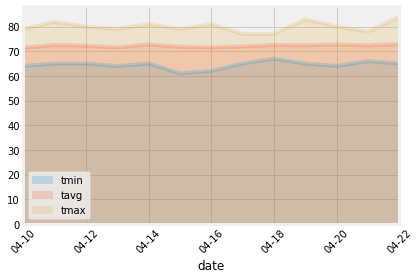

In [321]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind="area",stacked=False,rot=45,alpha=.2);
plt.xlabel("date");